# Import des outils / jeu de données

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from src.modelisation.univariate.parametric.models import create_models
from src.modelisation.univariate.parametric.plot import plot_estimations
from src.utils import init_notebook

In [2]:
init_notebook()

In [3]:
df = pd.read_csv(
    "data/kickstarter_1.csv",
    parse_dates=True,
)

In [4]:
event_times = df["day_succ"]
event_observed = df["Status"]

In [5]:
models = create_models()

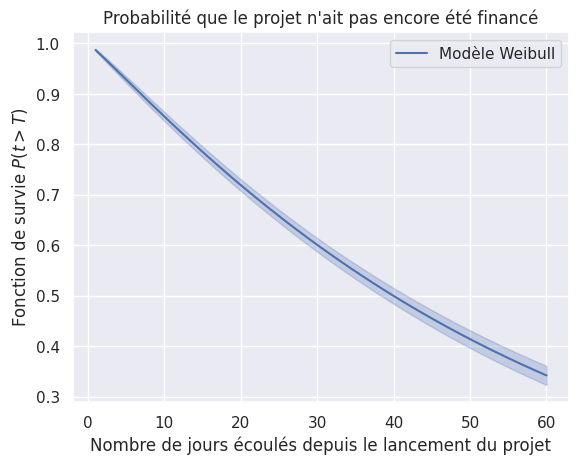

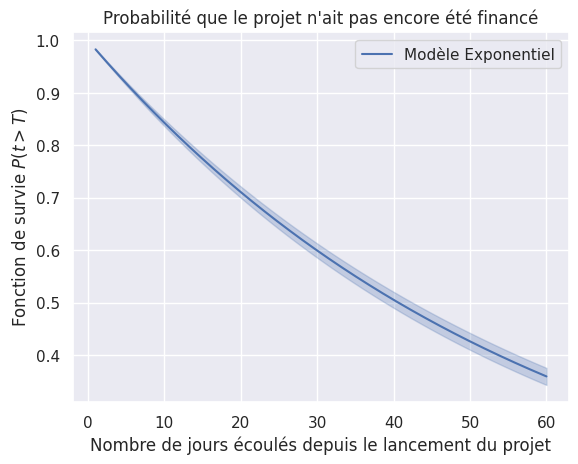

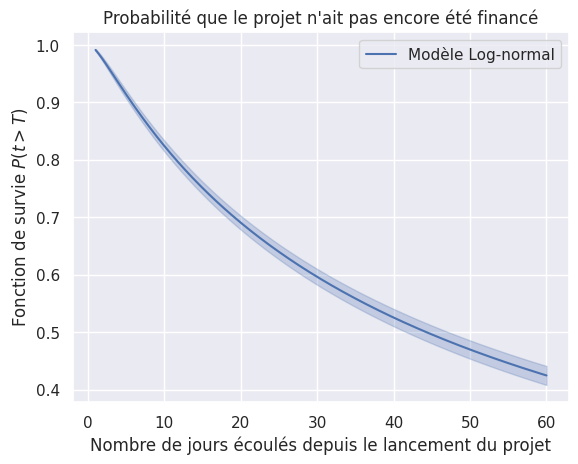

In [6]:
plot_estimations(models, event_times, event_observed)

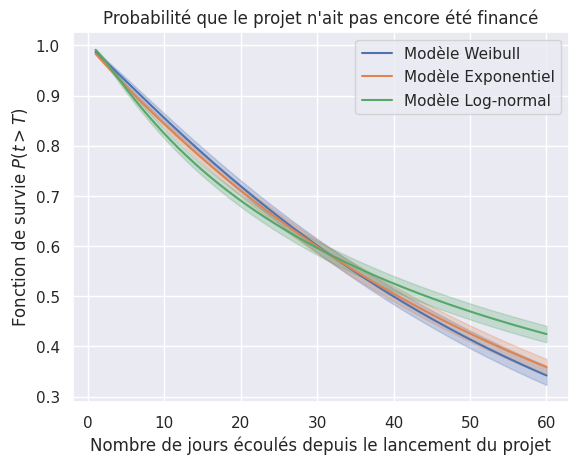

In [7]:
plot_estimations(models, event_times, event_observed, same_plot=True)